# Loan Predictions Based on Lending Club

# Part 1 - DEFINE THE PROBLEM

### Can we predict trustworthiness?
Given the previous history of a loan applicant can we accurately predict
<br/>
whether they will repay the loan or not?
#### --> Goals
        -> Help lending club make the right decision when giving out loans.
        -> Help the right applicants to recive loans.

In [1]:
#Importing Libraries
import os
import sys

sys.path.insert(1, '../src')

#analysis libraries
import numpy as np
import pandas as pd
from analyzation import analysis as al

#Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from visualization import visualize as vs

#building features
from features import build_features as bf

#Sckit learn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

#Tensorflow libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from models import train_model as tm

%matplotlib inline

#Info
__author__ = "Saitejas Mopuri"
__email__ = "saitejasmopuri@gmail.com"

## Part 2 - DISCOVER (EDA)

### ---- Loading the data ----

In [2]:
#Loading the data into a pandas dataframe
lending_data = pd.read_csv('../data/raw/lending_club_loan_two.csv')
lending_data_info = pd.read_csv('../data/raw/lending_club_info.csv', index_col='LoanStatNew')

In [3]:
lending_data_info

,Description
LoanStatNew,
loan_amnt,The listed amount of the loan applied for by t...
term,The number of payments on the loan. Values are...
int_rate,Interest Rate on the loan
installment,The monthly payment owed by the borrower if th...
grade,LC assigned loan grade
sub_grade,LC assigned loan subgrade
emp_title,The job title supplied by the Borrower when ap...
emp_length,Employment length in years. Possible values ar...
home_ownership,The home ownership status provided by the borr...


We have about 27 features in our data set 
with all their descriptions

we created a function so that it will be
easy to look up the descriptions when ever we
need them.

In [4]:
al.feat_info('term')

The number of payments on the loan. Values are in months and can be either 36 or 60.


### --Initial analysis of the data--

In [5]:
lending_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

We have about 396,030 entries 
which is good amount of data to 
train our algorithms.
<br/>
We have about 27 features and about 12 of them are numerical features and we have some missing data that we might have to drop or impute

In [6]:
#Lets check out the missing data
missing = lending_data.isnull().sum()
missing

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
dtype: int64

In [7]:
# Lets checkout what precentage they are missing
missing = (missing/len(lending_data))*100
missing.sort_values(ascending=False)

mort_acc                9.543469
emp_title               5.789208
emp_length              4.621115
title                   0.443148
pub_rec_bankruptcies    0.135091
revol_util              0.069692
address                 0.000000
verification_status     0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
home_ownership          0.000000
annual_inc              0.000000
purpose                 0.000000
issue_d                 0.000000
loan_status             0.000000
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
loan_amnt               0.000000
dtype: float64

#### We can see that mort_acc has the highest percentage about 9.5% and emp_title at 5.8% and emp_length at 4.62% and the rest are not more than 0.5%

In [8]:
#Lets convert the loan_status column to 1 and 0. 1 if loan is paid and 0 if charged off
# and store is in a loan_repaid column to check out the corelations.

In [9]:
lending_data['loan_repaid'] = lending_data['loan_status'].apply(lambda status: 1 if status == "Fully Paid" else 0)
lending_data[['loan_repaid', 'loan_status']]

,loan_repaid,loan_status
0,1,Fully Paid
1,1,Fully Paid
2,1,Fully Paid
3,1,Fully Paid
4,0,Charged Off
...,...,...
396025,1,Fully Paid
396026,1,Fully Paid
396027,1,Fully Paid
396028,1,Fully Paid


In [10]:
#Lets look at the correalations of the loan_repaid column
lending_data.corr()['loan_repaid'].sort_values()

int_rate               -0.247758
revol_util             -0.082373
dti                    -0.062413
loan_amnt              -0.059836
installment            -0.041082
open_acc               -0.028012
pub_rec                -0.019933
pub_rec_bankruptcies   -0.009383
revol_bal               0.010892
total_acc               0.017893
annual_inc              0.053432
mort_acc                0.073111
loan_repaid             1.000000
Name: loan_repaid, dtype: float64

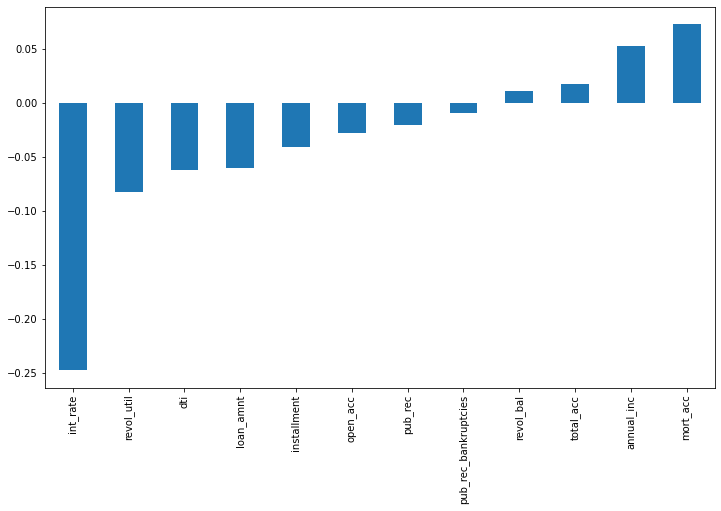

In [11]:
#Lets visulize the correlations
plt.figure(figsize=(12,7))
lending_data.corr()['loan_repaid'].sort_values().drop('loan_repaid').plot.bar()

### -- Cleaning Data --

In [12]:
#Lets checkout emp_title and emp_length
al.feat_info('emp_title')

The job title supplied by the Borrower when applying for the loan.*


In [13]:
al.feat_info('emp_length')

Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 


In [14]:
#Lets check out how many unique job titles there are
lending_data['emp_title'].nunique()

173105

In [15]:
#There are way too many job titles to perform feature engnieering on it 

In [16]:
#Lets check out employment length
lending_data['emp_length'].nunique()

11

In [17]:
# 11 unique values lets explore more for feature engnieering

In [18]:
lending_data['emp_length'].unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

It looks like the employment ranges from less the 1 year to greater than 10 years.
Lets check out the value counts

In [19]:
lending_data['emp_length'].value_counts()

10+ years    126041
2 years       35827
< 1 year      31725
3 years       31665
5 years       26495
1 year        25882
4 years       23952
6 years       20841
7 years       20819
8 years       19168
9 years       15314
Name: emp_length, dtype: int64

It looks like most our customers have been employed more than 10 years which makes since someone would like to get a loan once they have been working for a while


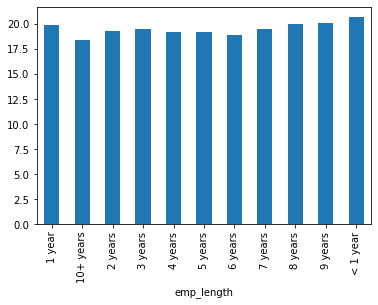

In [20]:
#Lets analyze this a little more
#What we want here is the ratio of charged off in repect to total loans
co = lending_data[lending_data['loan_status'] == 'Charged Off'].groupby('emp_length').count()['loan_status']
total = lending_data.groupby('emp_length').count()['loan_status']

perc = (co / total)*100

#The all look around 20% lets visulize
perc.plot.bar()

In [21]:
#Lets checkout the correlations in respect to mort_acc to fill in the 
# the missing values
lending_data.corr()['mort_acc'].sort_values(ascending=False)

mort_acc                1.000000
total_acc               0.381072
annual_inc              0.236320
loan_amnt               0.222315
revol_bal               0.194925
installment             0.193694
open_acc                0.109205
loan_repaid             0.073111
pub_rec_bankruptcies    0.027239
pub_rec                 0.011552
revol_util              0.007514
dti                    -0.025439
int_rate               -0.082583
Name: mort_acc, dtype: float64

In [22]:
lending_data[['total_acc', 'mort_acc']]

,total_acc,mort_acc
0,25.0,0.0
1,27.0,3.0
2,26.0,0.0
3,13.0,0.0
4,43.0,1.0
...,...,...
396025,23.0,0.0
396026,8.0,1.0
396027,23.0,0.0
396028,20.0,5.0


In [23]:
replace = lending_data.groupby('total_acc').median()['mort_acc']
lending_data['mort_acc'] = lending_data.apply(lambda entry: al.filler(entry['total_acc'],
                                                                   entry['mort_acc'], 
                                                                   replace[entry['total_acc']]), axis=1)

In [24]:
#title and purpose are almost the same column
lending_data = al.drop_columns(data=lending_data, cols=['emp_length', 'emp_title', 'title'])

In [25]:
lending_data.dropna(inplace=True)

In [26]:
lending_data.isnull().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
loan_repaid             0
dtype: int64

### ---- Data Visualization ----

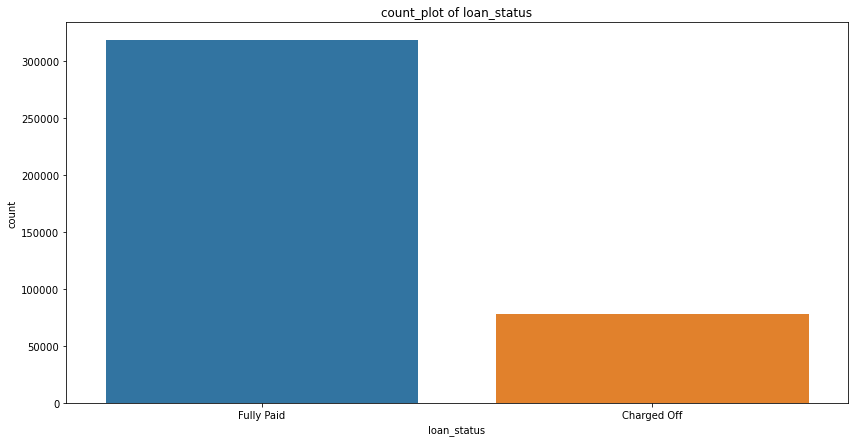

In [27]:
#Lets Check out how well our data is distrubuted
#By making a simple count plot
vs.visualization_plot(feature_x='loan_status', data=lending_data, plot_type='count')

As we can see our data is not very well distrubuted we have more "fully paid data" than "charged off data". This is what you would normally excpect since the lending company tries to allocate loans to people which they think they would most likely pay back.

In [28]:
#Lets checkout how well our loan amount is distributed
# By making a distplot

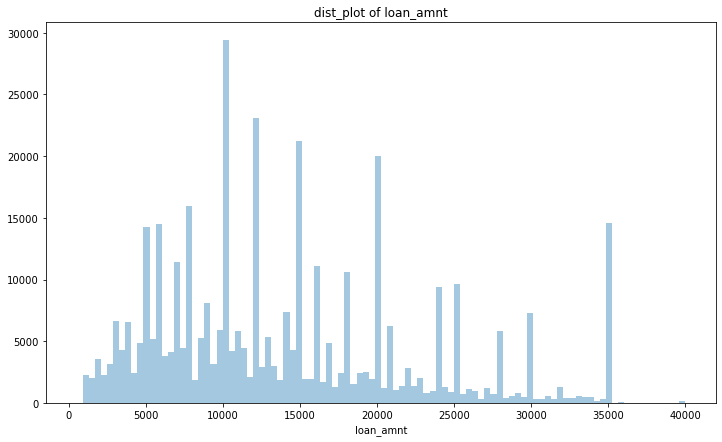

In [29]:
vs.visualization_plot(feature_x='loan_amnt', data=lending_data, plot_type='dist', size=(12,7))

As we can see here people tend to get loan amount that is rounded. For example: we see more loan amounts of 10000 rather than 10023. Which make sense beacuse people tend to get loan amounts that are rounded off.

In [30]:
#Lets checkout correlation of each feature with other features

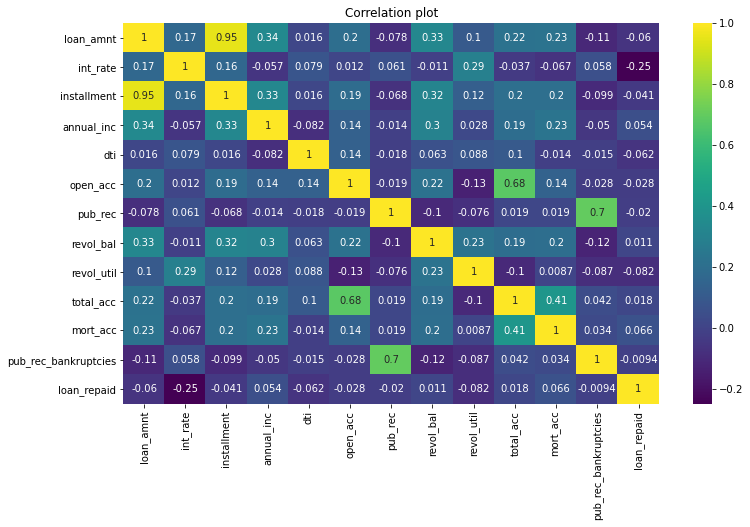

In [31]:
vs.corr_plot(lending_data.corr())

It looks like loan amount and installments are almost prefectly correlated let take a look and make sure they are not the same feature with different names

In [32]:
al.feat_info('installment')

The monthly payment owed by the borrower if the loan originates.


In [33]:
al.feat_info('loan_amnt')

The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.


In [34]:
#Okay that makes sense the higher your loan amount is the higger your installments
# It looks like they have a linear funciton to loan amount and installments

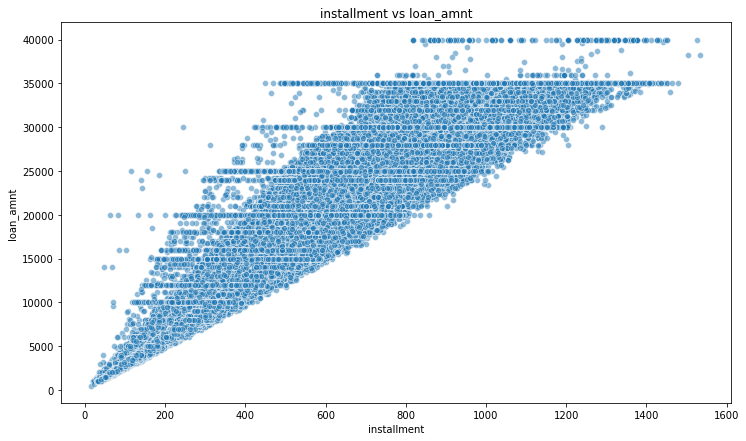

In [35]:
vs.visualization_plot(feature_x='installment', feature_y='loan_amnt', 
                   data=lending_data, size=(12,7), plot_type='scatter')

That looks good lets checkout the relation between loan status and loan amount. My hypothesis is that maybe people are taking higher amount of loans and fail to repay it back more often than people who take little amount.

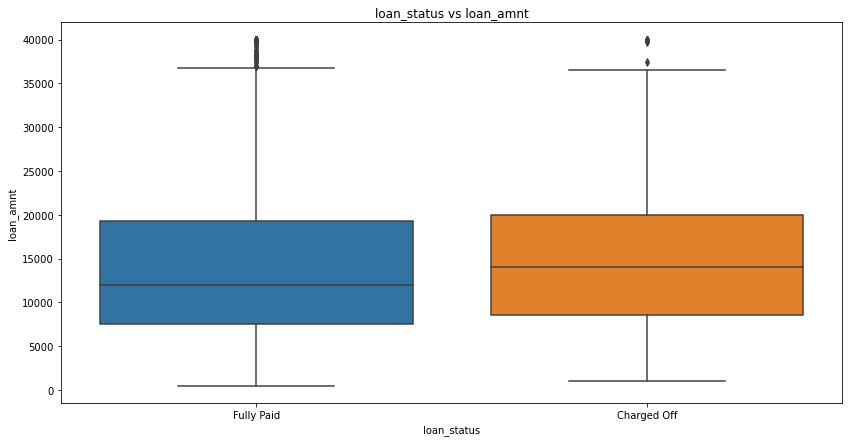

In [36]:
vs.visualization_plot(feature_x='loan_status', feature_y='loan_amnt', 
                   data=lending_data, plot_type='box')

Okay that is really hard to interept from this box plot. Lets do some more analysis on it

In [37]:
lending_data.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77523.0,15132.578074,8503.989092,1000.0,8575.0,14000.0,20000.0,40000.0
Fully Paid,317696.0,13875.478681,8302.172723,500.0,7500.0,12000.0,19275.0,40000.0


It looks the mean for charged off is slightly higher than fully paid but it isn't significantly different. The standard deviation is almost the same

In [38]:
#Lets checkout the grade and the subgrade features

In [39]:
lending_data['grade'].unique()

array(['B', 'A', 'C', 'E', 'D', 'F', 'G'], dtype=object)

In [40]:
sorted(lending_data['sub_grade'].unique())

['A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'G1',
 'G2',
 'G3',
 'G4',
 'G5']

In [41]:
lending_data['sub_grade'].nunique()

35

In [42]:
lending_data['grade'].nunique()

7

We can see that every grade has 5 unique sub grades. The "grade" feature is a sub feature of "sub_grade". For example: if the grade = 'A' then the sub_grade is one of the 5 values 'A1','A2','A3','A4','A5'.

In [43]:
#Lets visualize the distribution of the grades in respect to "loan_status"

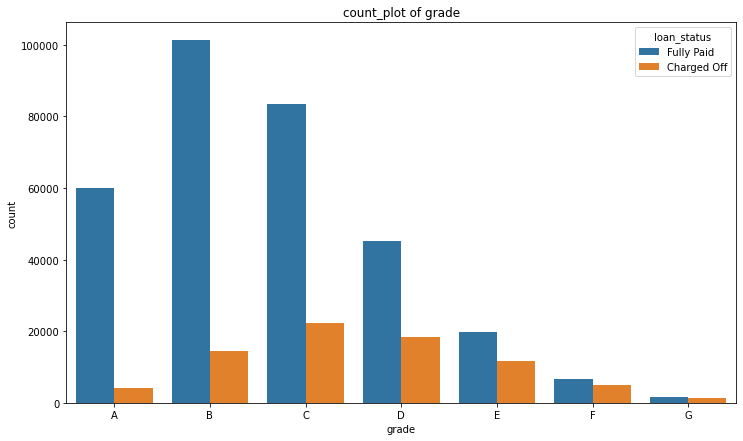

In [44]:
order = sorted(lending_data['grade'].unique())
vs.visualization_plot(feature_x='grade', hue='loan_status', 
                   plot_type='count', data=lending_data, size=(12,7),order=order)

Okay we can see that the grade 'A' loans are usally paid back but looks like the loans 'F' and 'G' are charged off more frequently than others.

In [45]:
#Lets visualize the sub grades as well

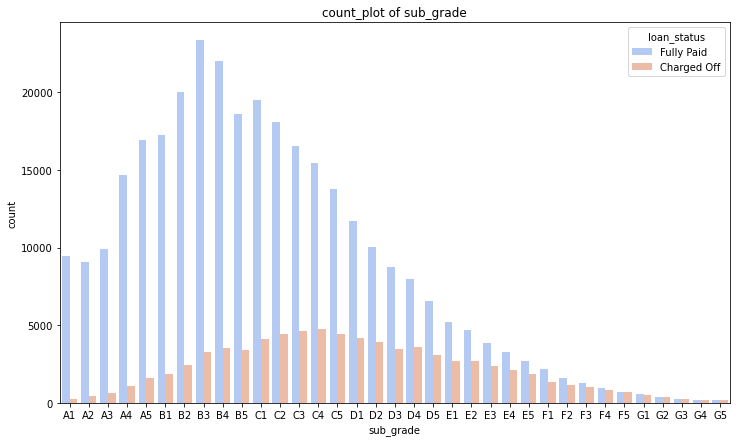

In [46]:
order = sorted(lending_data['sub_grade'].unique())
vs.visualization_plot(feature_x='sub_grade', hue='loan_status',
plot_type='count', data=lending_data, order=order, size=(12,7), palette='coolwarm')

Lets get a closer look ar F and G

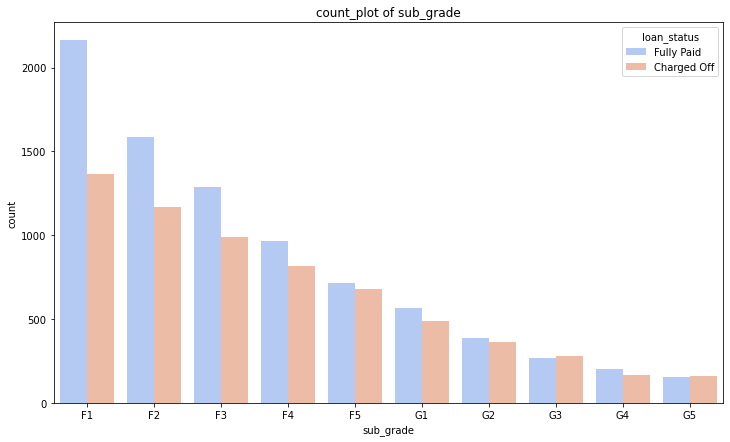

In [47]:
order = sorted(lending_data['sub_grade'].unique())[-10:] #Grab the last 10 sub_grades
vs.visualization_plot(feature_x='sub_grade', hue='loan_status',
plot_type='count', data=lending_data, order=order, size=(12,7), palette='coolwarm')

It looks like almost half of the G sub grade loans get charged off and sometimes more than half.

### -- Establishing a Baseline --

#### A good baseline would be to predict according to grade of the applicant. we will grant loans for people who are in the grade A-E and not grant loans for people in F-G

In [48]:
def baseline(df):
    if df == 'F' or df == 'G':
        return 0
    else:
        return 1

In [49]:
lending_data['grade']

0         B
1         B
2         B
3         A
4         C
         ..
396025    B
396026    C
396027    B
396028    C
396029    C
Name: grade, Length: 395219, dtype: object

In [50]:
baseline_lending_data =lending_data['grade'].apply(baseline)
baseline_lending_data

0         1
1         1
2         1
3         1
4         1
         ..
396025    1
396026    1
396027    1
396028    1
396029    1
Name: grade, Length: 395219, dtype: int64

In [51]:
print(classification_report(baseline_lending_data, lending_data['loan_repaid']))

              precision    recall  f1-score   support

           0       0.08      0.44      0.14     14785
           1       0.97      0.81      0.89    380434

    accuracy                           0.80    395219
   macro avg       0.53      0.63      0.51    395219
weighted avg       0.94      0.80      0.86    395219



[[  6480   8305]
 [ 71043 309391]]


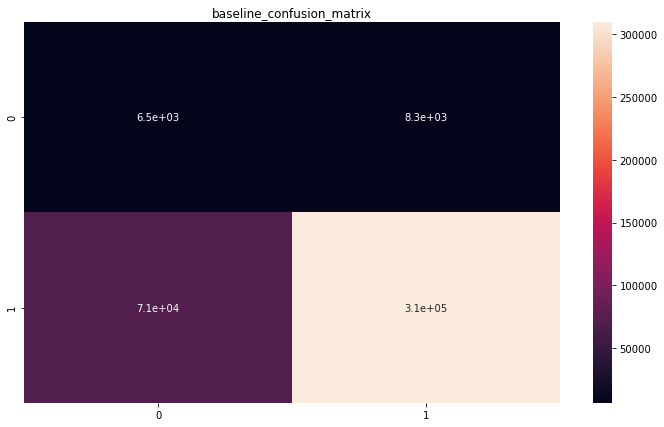

In [52]:
cm = confusion_matrix(baseline_lending_data, lending_data['loan_repaid'])
vs.confusion_plot(cm, title='baseline')

#### Our baseline model has an accuracy of 80% lets see if we can improve that

### -- Hypothesize solution --

In [53]:
#1 We can use a XGBClassifer since it is a classification problem
#2 We can use a deeply connect neural network with drop out and optimization

## Part 3 - DEVELOP

### -- Engineering features --

In [54]:
#Lets take a look at our data
lending_data.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,...,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,loan_repaid
0,10000.0,36 months,11.44,329.48,B,B4,RENT,117000.0,Not Verified,Jan-2015,...,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690",1
1,8000.0,36 months,11.99,265.68,B,B5,MORTGAGE,65000.0,Not Verified,Jan-2015,...,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113",1
2,15600.0,36 months,10.49,506.97,B,B3,RENT,43057.0,Source Verified,Jan-2015,...,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113",1
3,7200.0,36 months,6.49,220.65,A,A2,RENT,54000.0,Not Verified,Nov-2014,...,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813",1
4,24375.0,60 months,17.27,609.33,C,C5,MORTGAGE,55000.0,Verified,Apr-2013,...,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650",0


In [55]:
lending_data.select_dtypes(include='object').columns

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'earliest_cr_line',
       'initial_list_status', 'application_type', 'address'],
      dtype='object')

These cells are still in the form of objects lets convert them to numerical values so that our algorithm can interpret them

In [27]:
lending_data = bf.pre_processing(lending_data)
len(lending_data.columns)

79

Lets make 80/10/10 split of train/dev/test split

In [28]:
lending_features = lending_data.drop('loan_repaid', axis=1)
lending_repaid = lending_data['loan_repaid']

In [29]:
lend_feat_train, lend_feat_valid, lend_feat_test, lend_paid_train, lend_paid_valid, lend_paid_test = bf.pre_processing_split(data=(lending_features,lending_repaid))

In [30]:
print(len(lend_feat_train))
print(len(lend_feat_valid))
print(len(lend_feat_test))

351305
43914
39522


### -- Creating Models -- 

### First model XGBClassifier

In [60]:
#Training the XGBregressor model
n_estimators = [3000, 5000, 10000, 100000]
learning_rate = [0.1,0.05,0.01, 0.001,0.0001]
result = tm.xgb_model(n_estimators=n_estimators, 
                   learning_rate=learning_rate,
                  training_data=(lend_feat_train, lend_paid_train),
                   validation_data=(lend_feat_valid, lend_paid_valid),
                  testing_data=(lend_feat_test, lend_paid_test),
                    directory='xgb_performance',
                  filename='training_performance')
print(result)

       n_estimator  learning_rate  accuracy
index                                      
0           3000.0         0.1000  0.890922
1           3000.0         0.0500  0.889201
2           3000.0         0.0100  0.889201
3           3000.0         0.0010  0.889201
4           3000.0         0.0001  0.889201
5           5000.0         0.1000  0.890922
6           5000.0         0.0500  0.889201
7           5000.0         0.0100  0.889201
8           5000.0         0.0010  0.889201
9           5000.0         0.0001  0.889201
10         10000.0         0.1000  0.890922
11         10000.0         0.0500  0.889201
12         10000.0         0.0100  0.889201
13         10000.0         0.0010  0.889201
14         10000.0         0.0001  0.889201
15        100000.0         0.1000  0.890922
16        100000.0         0.0500  0.889201
17        100000.0         0.0100  0.889201
18        100000.0         0.0010  0.889201
19        100000.0         0.0001  0.889201


## Second model using hyper parameter search

In [32]:
model_bo = tm.hyper_parameter_search(train_data=(lend_feat_train, lend_paid_train),
                                     val_data=(lend_feat_valid, lend_paid_valid),
                                     project_name='loan_predictions_hp_search')


INFO:tensorflow:Oracle triggered exit

        The hyperparameter search is complete. The optimal units
        36 and the optimal learning rate is 
        0.001 and the optimal dropout
        0.0 and the optimal activation
        sigmoid.


In [34]:
model_bo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 36)                2844      
_________________________________________________________________
dropout (Dropout)            (None, 36)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 36)                1332      
_________________________________________________________________
dropout_1 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 36)                1332      
_________________________________________________________________
dropout_2 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

In [2]:
history, model_bo = tm.model_fit(model_bo,train_data=(lend_feat_train, lend_paid_train),
                                     val_data=(lend_feat_valid, lend_paid_valid), monitor='accuracy')

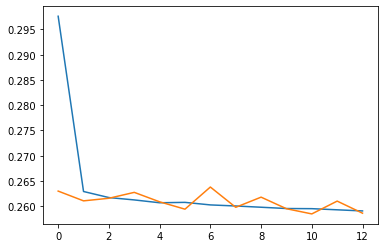

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Third model tuning the neural network by hand

In [65]:
model_3 = Sequential()

model_3.add(Dense(78,activation='relu'))
#We dont want any dropouts on the features

model_3.add(Dense(78,activation='relu'))
model_3.add(Dropout(0.6)) 
# We like to have high drop out here
#Because we might overfit

model_3.add(Dense(39,activation='relu'))
model_3.add(Dropout(0.2))

model_3.add(Dense(19,activation='relu'))
model_3.add(Dropout(0.2))

model_3.add(Dense(units=1, activation='sigmoid'))

model_3.compile(loss='binary_crossentropy', optimizer='adam')
# Our loss function is binary_crossentropy becuse we predict 1 or 0

In [1]:
history_3, model_3 = tm.model_fit(model_3,train_data=(lend_feat_train, lend_paid_train),
                                     val_data=(lend_feat_valid, lend_paid_valid), monitor='loss')

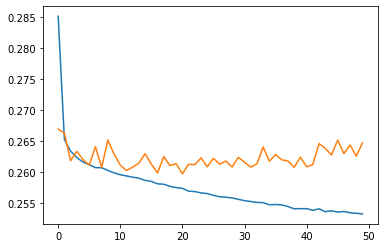

In [67]:
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])

### -- Testing Models --

In [3]:
#The best we got is the neural netwrok models with 89% accuracy and 94% F-1 Score

In [74]:
predictions = model_bo.predict_classes(lend_feat_test)

In [75]:
print(classification_report(predictions,lend_paid_test))

              precision    recall  f1-score   support

           0       0.47      0.93      0.62      3925
           1       0.99      0.89      0.94     35597

    accuracy                           0.89     39522
   macro avg       0.73      0.91      0.78     39522
weighted avg       0.94      0.89      0.90     39522



[[ 3635   290]
 [ 4081 31516]]


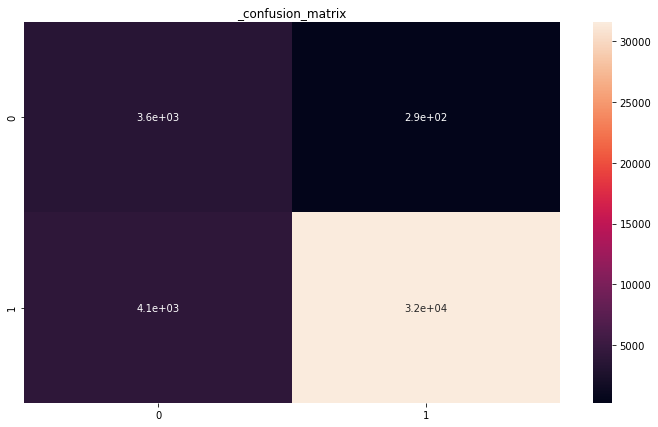

In [76]:
cm = confusion_matrix(predictions,lend_paid_test)
vs.confusion_plot(cm)

In [70]:
predictions = model_3.predict_classes(lend_feat_test)
print(classification_report(predictions,lend_paid_test))

              precision    recall  f1-score   support

           0       0.43      1.00      0.60      3364
           1       1.00      0.88      0.94     36158

    accuracy                           0.89     39522
   macro avg       0.72      0.94      0.77     39522
weighted avg       0.95      0.89      0.91     39522



[[ 3348    16]
 [ 4368 31790]]


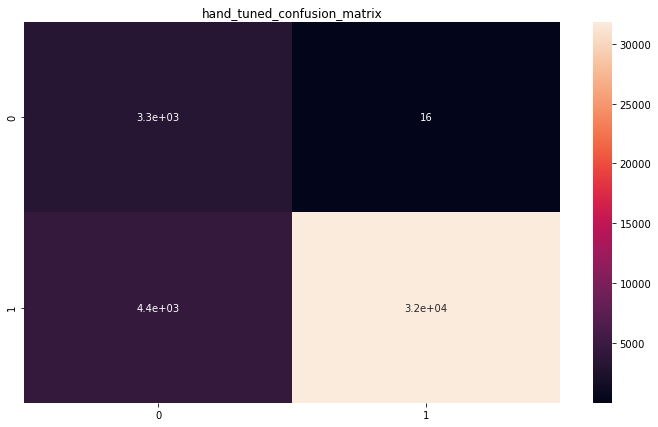

In [72]:
cm = confusion_matrix(predictions,lend_paid_test)
vs.confusion_plot(cm, title="hand_tuned")

-- <i> Depending on our problem we can choose one of these two models. If the economic conditions are bad we can use the second model to eliminate as many false positives as possible. If the economy is doing very well we can use the first model that has a little bit more false positives.--